# Telecom Churn Prediction | Neural Network Classifier

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Load preprocessed data

In [2]:
df_preprocessed = pd.read_csv('../data/processed/preprocessed_telco.csv')

In [3]:
df_preprocessed.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0.013889,0.115423,0.003437,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0.472222,0.385075,0.217564,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.027778,0.354229,0.012453,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0.625000,0.239303,0.211951,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.027778,0.521891,0.017462,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


## Independent and Dependent variables

In [4]:
X = df_preprocessed.drop('Churn_Yes', axis=1)
y = df_preprocessed['Churn_Yes']

In [5]:
y.value_counts()

Churn_Yes
0    5174
1    1869
Name: count, dtype: int64

## Converting data to numpy arrays

In [6]:
X = X.values
y = y.values

## Train Test Split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 30)
(1409, 30)
(5634,)
(1409,)


## Hanlde class imbalance 

In [9]:
from sklearn.utils import class_weight

In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [11]:
class_weights_dict = dict(enumerate(class_weights))

## Neural Network Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(32, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\sanid\VS Projects\Telecom_Churn_Prediction\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [14]:
model.compile(
    optimizer=optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [16]:
history = model.fit(
    x_train,
    y_train, 
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6510 - auc: 0.7012 - loss: 0.6976 - val_accuracy: 0.7400 - val_auc: 0.7939 - val_loss: 0.6093
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7531 - auc: 0.8150 - loss: 0.6083 - val_accuracy: 0.7116 - val_auc: 0.8065 - val_loss: 0.5635
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7399 - auc: 0.8329 - loss: 0.5570 - val_accuracy: 0.7116 - val_auc: 0.8136 - val_loss: 0.5648
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - auc: 0.8444 - loss: 0.5330 - val_accuracy: 0.7178 - val_auc: 0.8175 - val_loss: 0.5582
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7297 - auc: 0.8256 - loss: 0.5501 - val_accuracy: 0.7196 - val_auc: 0.8191 - val_loss: 0.5543
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - auc: 0.8345 - loss: 0.5414 - val_accuracy: 0.7205 - val_auc: 0.8201 - val_loss: 0.5598
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate the Model

### Plot loss

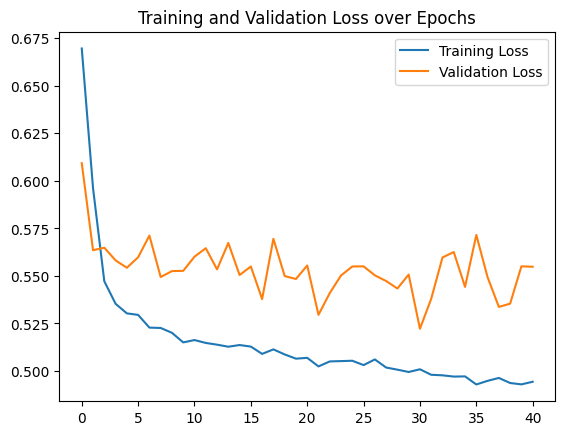

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

### Test Accuracy

In [18]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7456 - auc: 0.8321 - loss: 0.5173 
Test Accuracy: 0.7573, Test AUC: 0.8371


In [19]:
y_pred_prob = model.predict(x_test)

y_pred = (y_pred_prob > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


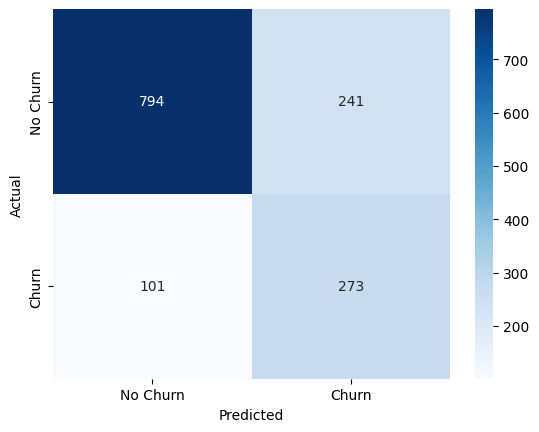

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Plot ROC Curve

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC-AUC score: 0.836851894908161


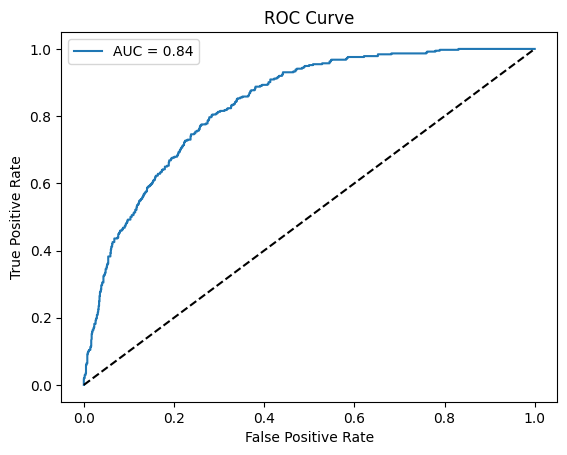

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = model.predict(x_test)
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC score:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()